In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

plt.rcParams['figure.figsize'] = [20, 4]

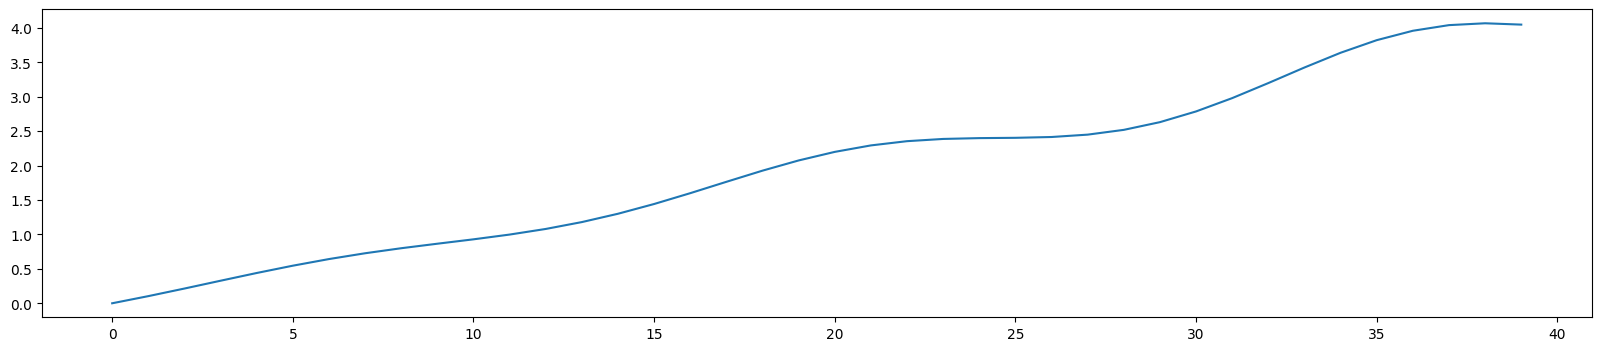

In [137]:
class DataGenerator:
    def __init__(self, f):
        self.f = f

    def __call__(self, n):
        y = np.array(self.f(np.arange(n)), dtype=np.float32)
        return y

dgen = DataGenerator(lambda x: 0.1*x+x*0.01*np.sin(x/16*2*np.pi))
plt.plot(dgen(40))

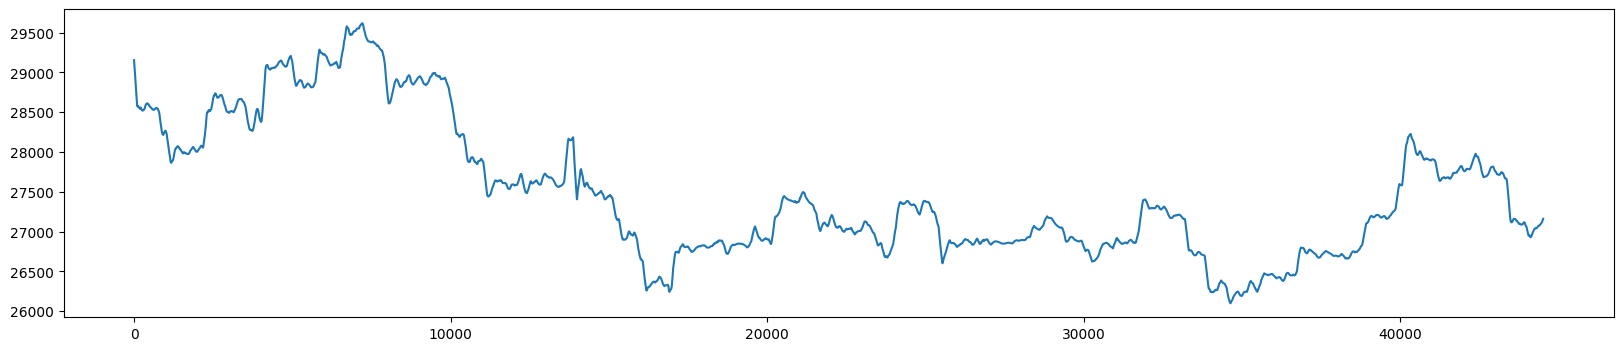

In [15]:
df = pd.read_csv("./data/BTCUSD_PERP-1m-2023-05.csv")
timeseries = df[["close"]].rolling(120).mean().values.astype('float32')[120:]

plt.plot(timeseries);

In [22]:
def filter_dset(dset, dt, dp):
    ids = []    
    for i in range(dt, len(dset)):
        if (dset[i] - dset[i-dt])/dset[i-dt] > dp:
            ids.append(i)
    return ids

def create_dset(dset, lookback, ids=None):
    """Transform a time series into a prediction dset
    
    Args:
        dset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    if ids is None:
        ids = list(range(lookback-1, len(dset)-lookback))
    else:
        ids = [i for i in ids if i < len(dset)-lookback]

    for i in ids:
        i -= lookback-1
        feature = dset[i:i+lookback]
        target = dset[i+1:i+lookback+1].copy()
        target[-1] = dset[i+2*lookback-1] #(dset[i+1:i+lookback+1] - dset[i:i+lookback])/dset[i:i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


# train-test split for time series
train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

lookback = 8
dp = 0.006
X_train, y_train = create_dset(train, lookback=lookback, ids=None)#filter_dset(train, lookback, dp))
X_test, y_test = create_dset(test, lookback=lookback, ids=None)#ffilter_dset(test, lookback, dp))
train_size, test_size = y_train.shape[0], y_test.shape[0]
print(y_train.shape, y_test.shape)

torch.Size([31148, 8, 1]) torch.Size([13342, 8, 1])


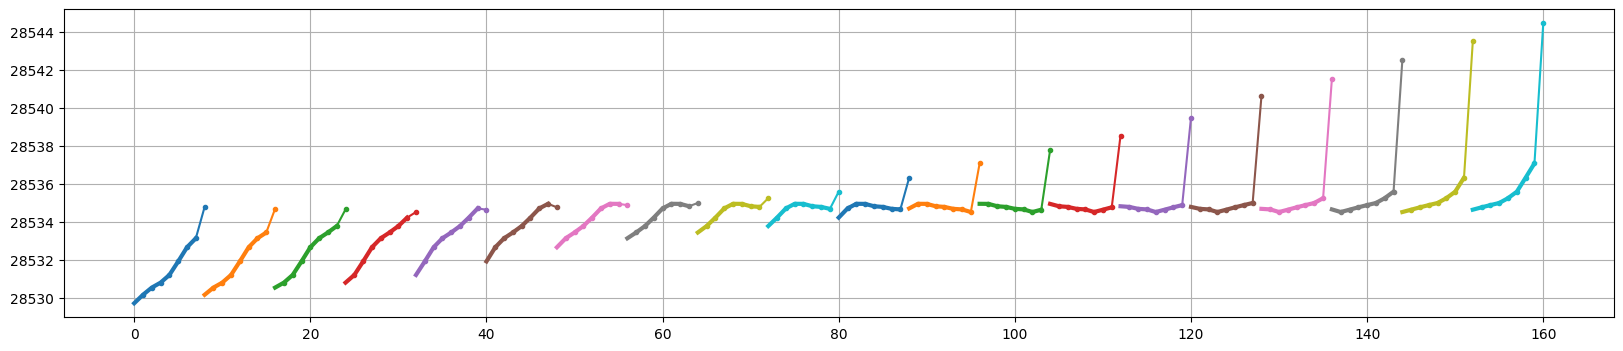

In [24]:
n1, n2 = 300, 320
for i, x in enumerate(X_train[n1:n2]):
    plt.plot(list(range(i*lookback, lookback+i*lookback)), x, "-", linewidth=3)
for i, x in enumerate(y_train[n1:n2]):
    plt.plot(list(range(i*lookback+1, lookback+i*lookback+1)), x, ".-")
plt.grid("on")

In [27]:
class AirModel(nn.Module):
    def __init__(self, n_lstm=8, n_linear=8):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=n_lstm, num_layers=1, batch_first=True)
        self.linear_trans = nn.Linear(n_lstm, n_linear)
        self.linear_inner = nn.Linear(n_linear, n_linear)
        self.linear_out = nn.Linear(n_linear, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear_trans(x)
        # x = nn.ReLU()(x)
        # x = self.linear_inner(x)
        x = nn.ReLU()(x)
        x = self.linear_out(x)
        return x
    
    def predict(self, x):
        dx = self.forward(x)[:, -1, :]
        return x[:, -1]#*(dx + 1)
model = AirModel(8, 8)

In [28]:
optimizer = optim.Adam(model.parameters(), 0.01)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 9
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %08.2f, test RMSE %08.2f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 13769.59, test RMSE 13152.90
Epoch 1: train RMSE 00892.76, test RMSE 00711.68
Epoch 2: train RMSE 00880.61, test RMSE 00808.96
Epoch 3: train RMSE 00881.12, test RMSE 00835.99
Epoch 4: train RMSE 00880.69, test RMSE 00823.02
Epoch 5: train RMSE 00880.73, test RMSE 00824.82
Epoch 6: train RMSE 00881.53, test RMSE 00843.65
Epoch 7: train RMSE 00881.25, test RMSE 00788.41
Epoch 8: train RMSE 00880.68, test RMSE 00822.42


(0.0, 1000.0)

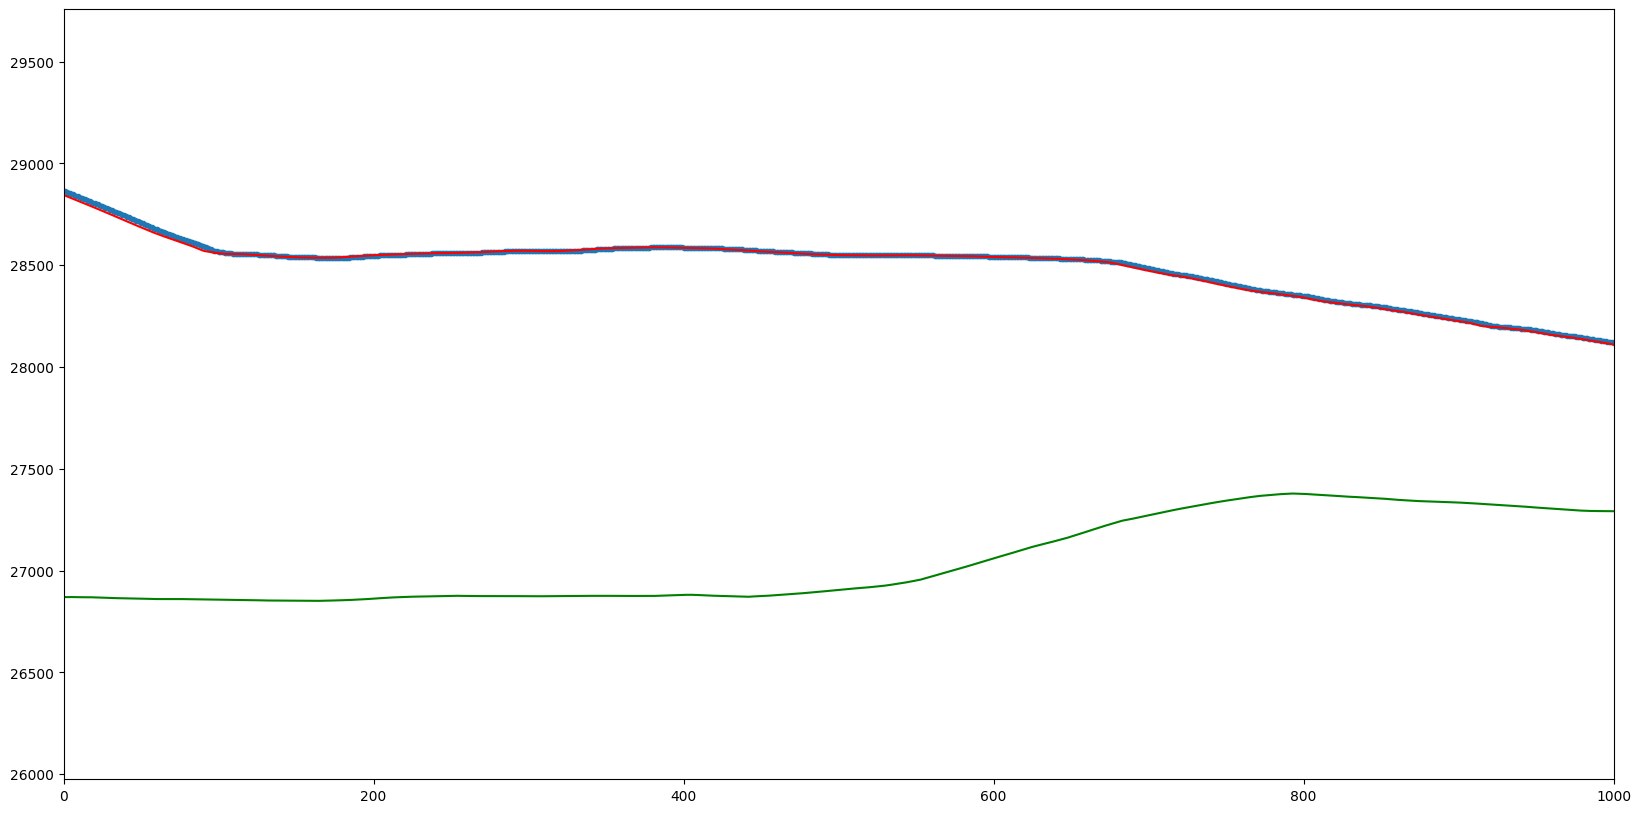

In [8]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model.predict(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[:train_size] = model.predict(X_train)#[:, -1, :]
    # shift test predictions for plotting
    #test_plot = np.ones_like(timeseries) * np.nan
    test_plot = model.predict(X_test)#[:, -1, :]
# plot
plt.subplots(figsize=(20, 10))
plt.plot(timeseries, ".")
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.xlim([0, 1000])

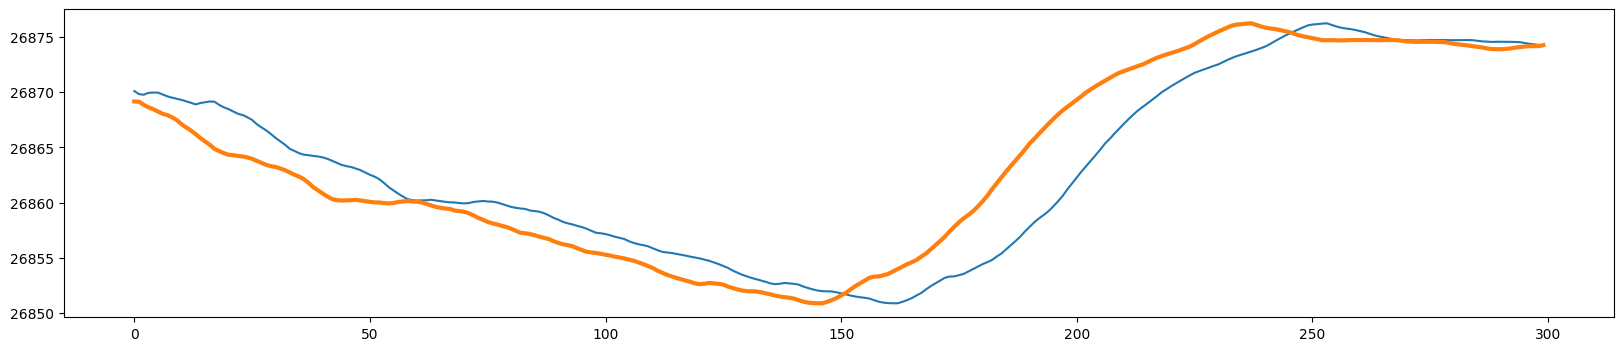

In [10]:
plt.plot(test_plot[:300])
plt.plot(y_test[:300, -1], linewidth=3)